MNIST 数据集下载后有4个二进制 IDX 文件：

```
train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
```

其中图像文件的数据格式为：
```
TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000803(2051) magic number 
0004     32 bit integer  60000            number of images 
0008     32 bit integer  28               number of rows 
0012     32 bit integer  28               number of columns 
0016     unsigned byte   ??               pixel 
0017     unsigned byte   ??               pixel 
........ 
xxxx     unsigned byte   ??               pixel
```

文件头信息包含 4 个 unsinged int32 整型数据，分别是 魔数、图片数、图片宽度、图片长度。
后面的数据是所有图像的像素的，每个byte一个像素点。图片的长宽都是 28，所以每张图片长度为 28*28。
像素值取值范围是 0～255。

可以使用 python 的 struct 模块读取二进制数据，将图像像素转为 numpy 矩阵，因而可以使用下面的函数解析图像数据：

In [6]:
import struct
import numpy as np

def decode_idx3_ubyte(idx3_ubyte_file):
    with open(idx3_ubyte_file, 'rb') as f:
        print('解析文件：', idx3_ubyte_file)
        fb_data = f.read()

    offset = 0
    fmt_header = '>iiii'    # 以大端法读取4个 unsinged int32
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, fb_data, offset)
    print('魔数：{}，图片数：{}'.format(magic_number, num_images))
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(num_rows * num_cols) + 'B'

    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        im = struct.unpack_from(fmt_image, fb_data, offset)
        images[i] = np.array(im).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images

标签数据文件的格式为：
```
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description] 
0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
0004     32 bit integer  60000            number of items 
0008     unsigned byte   ??               label 
0009     unsigned byte   ??               label 
........ 
xxxx     unsigned byte   ??               label
```

文件头是两个 unsinged int32 整型数据：魔数和标签数，后面每一个 byte 是一个标签值，标签值为 0～9。同样使用 struct 读取：

In [7]:
import struct

def decode_idx1_ubyte(idx1_ubyte_file):
    with open(idx1_ubyte_file, 'rb') as f:
        print('解析文件：', idx1_ubyte_file)
        fb_data = f.read()

    offset = 0
    fmt_header = '>ii'  # 以大端法读取两个 unsinged int32
    magic_number, label_num = struct.unpack_from(fmt_header, fb_data, offset)
    print('魔数：{}，标签数：{}'.format(magic_number, label_num))
    offset += struct.calcsize(fmt_header)
    labels = []

    fmt_label = '>B'    # 每次读取一个 byte
    for i in range(label_num):
        labels.append(struct.unpack_from(fmt_label, fb_data, offset)[0])
        offset += struct.calcsize(fmt_label)
    return labels

解析出了图像像素和标签值后，就可以使用 cv2 模块将像素矩阵保存为图像文件，根据标签值保存在不同的目录下：

In [8]:
import gzip
import numpy as np
import os
import cv2     # conda install -c conda-forge opencv

def check_folder(folder):
    """检查文件文件夹是否存在，不存在则创建"""
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(folder)
    else:
        if not os.path.isdir(folder):
            os.mkdir(folder)


def export_img(exp_dir, img_ubyte, lable_ubyte):
    """
    生成数据集
    """
    check_folder(exp_dir)
    images = decode_idx3_ubyte(img_ubyte)
    labels = decode_idx1_ubyte(lable_ubyte)

    nums = len(labels)
    for i in range(nums):
        img_dir = os.path.join(exp_dir, str(labels[i]))
        check_folder(img_dir)
        img_file = os.path.join(img_dir, str(i)+'.png')
        imarr = images[i]
        cv2.imwrite(img_file, imarr)


def parser_mnist_data(data_dir):

    train_dir = os.path.join(data_dir, 'train')
    train_img_ubyte = os.path.join(data_dir, 'train-images-idx3-ubyte')
    train_label_ubyte = os.path.join(data_dir, 'train-labels-idx1-ubyte')
    export_img(train_dir, train_img_ubyte, train_label_ubyte)

    test_dir = os.path.join(data_dir, 'test')
    test_img_ubyte = os.path.join(data_dir, 't10k-images-idx3-ubyte')
    test_label_ubyte = os.path.join(data_dir, 't10k-labels-idx1-ubyte')
    export_img(test_dir, test_img_ubyte, test_label_ubyte)


if __name__ == '__main__':
    data_dir = 'mnist_data/'   # 会在ipynb的同一层目录下创建该文件夹
    
    import requests
    
    url_list = ["http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
               "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
               "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
               "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"]
    for url in url_list:
        gz_name = url.split('/')[-1]
        name = gz_name.split('.')[0]
        if not os.path.exists(gz_name) and not os.path.exists(name):
            r = requests.get(url, allow_redirects=True)
            open(data_dir + gz_name, 'wb').write(r.content)
        if not os.path.exists(name):
            os.system('gunzip ' + data_dir + gz_name)
            
    parser_mnist_data(data_dir)

最后得到具有如下目录结构的数据集，进入对应的目录，可以查看每张图片
```
mnist_data/
    |----train/
        |----0/
            |----0.png
        |----1/
            |----1.png
...
    |----test/
...
```

也可以读取之后转成numpy数组并打印到屏幕

<class 'numpy.ndarray'>
(28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253 159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 1

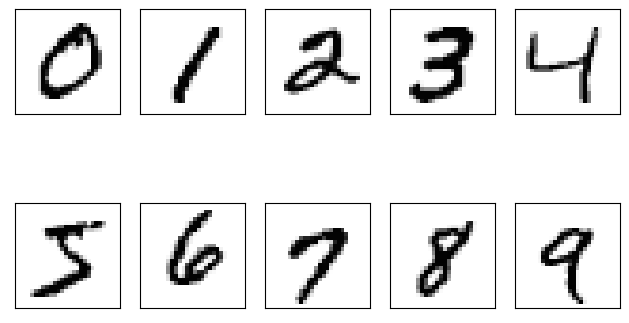

In [11]:
import os
import struct
import numpy as np

path = 'mnist_data/'

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True, )

ax = ax.flatten()

X_train, Y_train = load_mnist(path)

img = X_train[Y_train == 0][0].reshape(28, 28)  # 每个数字取第一张图片

print(type(img))  # <class 'numpy.ndarray'>
print(img.shape)  # (28, 28)
np.set_printoptions(linewidth=400)
print(img)       # 打印灰度值

for i in range(10):
    img = X_train[Y_train == i][0].reshape(28, 28)  # 每个数字取一张
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

    